In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import sys
import numpy as np

### softmax回归的从零开始实现

#### 获取和读取数据

In [2]:
batch_size = 256
train_data = torchvision.datasets.FashionMNIST('./data/FashionMNIST',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_data = torchvision.datasets.FashionMNIST('./data/FashionMNIST',train=False,transform=torchvision.transforms.ToTensor(),download=True)

In [3]:
train_iter = torch.utils.data.DataLoader(train_data,batch_size,shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data,batch_size,shuffle=False)

#### 初始化模型参数

In [4]:
num_inputs = 28 * 28
num_outputs = 10
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)),dtype=torch.float)
b = torch.zeros(num_outputs,dtype=torch.float)

In [5]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

#### 实现softmax运算:
    矩阵X的行数是样本数，列数是输出个数
    先通过exp函数对每个元素做指数运算，再对exp矩阵同行元素求和，最后令矩阵每行各元素与该行元素之和相除
![softmax](./img/3.4/softmax.png)

In [6]:
def softmax(z):
#     return np.exp(z) / np.exp(z).sum(dim=1,keepdim=True)
    z_exp = z.exp()
    j = z_exp.sum(dim=1,keepdim=True)
    return z_exp / j

In [7]:
# 对于随机输入，我们将每个元素变成了非负数，且每一行和为1
X = torch.rand((2, 5))
X_prob = softmax(X)
print(type(X_prob))
print(X_prob, X_prob.sum(dim=1))

<class 'torch.Tensor'>
tensor([[0.2953, 0.2050, 0.1884, 0.1223, 0.1890],
        [0.1632, 0.2057, 0.2492, 0.1438, 0.2380]]) tensor([1.0000, 1.0000])


#### 定义模型
![model](./img/3.4/model.png)

In [8]:
def net(x):
    O = torch.mm(x.view(-1,num_inputs),w) + b
    y_hat = softmax(O)
    return y_hat

#### 定义损失函数
![cross-entropy](./img/3.4/cross-entropy.png)

In [9]:
# 可以使用 gather 函数
y_hat = torch.tensor([[0.1,0.3,0.6]
                      ,[0.3,0.2,0.5]])
y = torch.tensor([2,1])
y_hat.gather(1,y.view(-1,1)) # dim: 0 按列查找 1 按行查找    index：索引

tensor([[0.6000],
        [0.2000]])

In [10]:
def cross_entropy(y_hat,y):
    y = y.view(-1,1)
    return - torch.log(y_hat.gather(1,y)).sum()

#### 计算分类准确率
    把预测概率最大的类别作为输出类别,与真实类别y一致，说明这次预测是正确的
    
    分类准确率即正确预测数量与总预测数量之比

In [11]:
def accuracy(y_hat,y):
#     return (y_hat.argmax(dim=1) == y).float().mean().item()
    return ((y_hat.argmax(dim=1) == y).float().sum() / len(y_hat)).item()

In [12]:
accuracy(y_hat,y)

0.5

In [13]:
def evaluate_accuracy(data_iter,net):
    acc_sum,n = 0.0 , 0 # acc_sum：总的正确率   n：数据集个数
    for x,y in data_iter:
        y_pre = net(x)
        acc_sum += (y_pre.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [14]:
evaluate_accuracy(test_iter,net)

0.1438

#### 训练模型

In [15]:
num_epochs , lr = 5,0.1

In [16]:
def train(num_epochs,train_iter,test_iter,net,loss_fn,batch_size,params=None,lr=None,optimizer=None):
    for epoch in range(num_epochs):
        train_loss_sum,train_acc_sum,n = 0.0,0.0,0
        for x,y in train_iter:
            y_hat = net(x)
            loss = loss_fn(y_hat,y)
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            loss.backward()
            if optimizer is not None:
                optimizer.step()
            else:
                for param in params:
                    param.data -= param.grad * lr / batch_size
                    
            train_acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()
            train_loss_sum += loss.item()
            n += y.shape[0]
            
        test_acc = evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc: %.3f,test acc: %.3f' % (epoch+1,train_loss_sum/n,train_acc_sum/n * 100,test_acc))

In [17]:
train(num_epochs,train_iter,test_iter,net,cross_entropy,batch_size,params=[w,b],lr=lr,)

epoch 1,loss 0.7850,train acc: 75.023,test acc: 0.795
epoch 2,loss 0.5699,train acc: 81.385,test acc: 0.812
epoch 3,loss 0.5251,train acc: 82.667,test acc: 0.819
epoch 4,loss 0.5015,train acc: 83.222,test acc: 0.825
epoch 5,loss 0.4862,train acc: 83.673,test acc: 0.829


#### 预测

In [19]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [21]:
def show_fashion_mnist(x,y):
    _,figs = plt.subplots(1,len(x),figsize=(12,12))
    for f,i,l in zip(figs,x,y):
        f.imshow(i.view(28,28).numpy())
        f.set_title(l)
    
    plt.show()

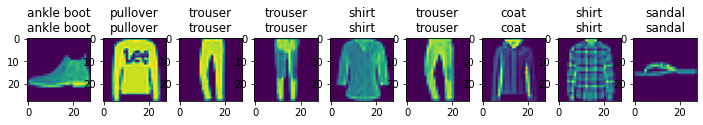

In [24]:
x,y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(x).argmax(dim=1).numpy())
titles = [true + '\n' + pre for true,pre in zip(true_labels,pred_labels)]

show_fashion_mnist(x[0:9],titles[0:9])

### softmax回归的简洁实现

In [25]:
import torch
from torch.nn import init

#### 获取和读取数据

In [26]:
batch_size = 256
train_data = torchvision.datasets.FashionMNIST('./data/FashionMNIST',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_data = torchvision.datasets.FashionMNIST('./data/FashionMNIST',train=False,transform=torchvision.transforms.ToTensor(),download=True)

In [27]:
train_iter = torch.utils.data.DataLoader(train_data,batch_size,shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data,batch_size,shuffle=False)

#### 定义和初始化模型
    softmax回归的输出层是一个全连接层，所以用一个线性模块即可
    前面数据返回的每个 batch 样本 x 的形状为(batch_size, 1, 28, 28)
    所以要先用 view() 将 x 的形状转换成(batch_size, 784)才送入全连接层

In [28]:
num_inputs = 784
num_outputs = 10

In [29]:
class Net(torch.nn.Module):
    def __init__(self,num_inputs,num_outputs):
        super(Net,self).__init__()
        self.fc = torch.nn.Linear(num_inputs,num_outputs)
        
    def forward(self,x):
        out = self.fc(x.view(x.shape[0],-1))
        return out

In [32]:
net = Net(num_inputs,num_outputs)
net

Net(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [34]:
# 使用均值为0、标准差为0.01的正态分布随机初始化模型的权重参数
# w = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)),dtype=torch.float)
# b = torch.zeros(num_outputs,dtype=torch.float)
init.normal_(net.fc.weight,mean=0,std=0.01)
init.constant_(net.fc.bias,val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

#### softmax和交叉熵损失函数
    分开定义softmax运算和交叉熵损失函数可能会造成数值不稳定
    因此，PyTorch提供了一个包括 softmax 运算和交叉熵损失计算的函数

In [35]:
loss_fn = torch.nn.CrossEntropyLoss()

#### 定义优化算法

In [36]:
# 使用学习率为0.1的小批量随机梯度下降作为优化算法
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(),lr=lr)

#### 训练模型

In [38]:
epochs = 5
for epoch in range(epochs):
    train_loss_sum,train_acc_sum,train_n = 0.0,0.0,0
    test_acc_sum,test_n = 0.0,0
    for x,y in train_iter:
        y_hat = net(x)
        loss = loss_fn(y_hat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()
        train_loss_sum += loss.item()
        train_n += y.shape[0]
    
    for x,y in test_iter:
        y_hat = net(x)
        loss = loss_fn(y_hat,y)
        
        test_acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()
        test_n += y.shape[0]
        
    print('epoch: %d train_loss: %.4f train_acc: %.3f test_acc: %.3f'%(epoch + 1
                                                                       ,train_loss_sum / train_n,train_acc_sum / train_n
                                                                       ,test_acc_sum / test_n))

epoch: 1 train_loss: 0.0019 train_acc: 0.841 test_acc: 0.829
epoch: 2 train_loss: 0.0018 train_acc: 0.843 test_acc: 0.820
epoch: 3 train_loss: 0.0018 train_acc: 0.846 test_acc: 0.826
epoch: 4 train_loss: 0.0018 train_acc: 0.846 test_acc: 0.835
epoch: 5 train_loss: 0.0017 train_acc: 0.849 test_acc: 0.829


#### 预测